# Question: What is the text-based sentiment of reddit comments? How text-based sentiment is correlated with number of upvotes?

In [1]:
from pyspark.sql import SparkSession
from operator import add
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk 
nltk.download('vader_lexicon')

spark = SparkSession.builder\
        .master("spark://192.168.2.186:7077") \
        .appName("Group14_Application")\
        .config("spark.cores.max", 4)\
        .getOrCreate()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/opt/spark/conf/spark-env.sh: line 79: export: `192.168.2.186': not a valid identifier
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/13 15:01:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import matplotlib.pyplot as plt

## Load data and intilize sentiment analyzer

In [3]:
sia = SentimentIntensityAnalyzer()

In [4]:
data = spark.read.json("sample_data.json") # Load the sample data

In [5]:
data.show(vertical=True) # Show data to see that it loads correctly

-RECORD 0--------------------------------------
 author                 | Dethcola             
 author_cakeday         | null                 
 author_flair_css_class |                      
 author_flair_text      | Clairemont           
 body                   | A quarry             
 can_gild               | true                 
 controversiality       | 0                    
 created_utc            | 1506816000           
 distinguished          | null                 
 edited                 | false                
 gilded                 | 0                    
 id                     | dnqik14              
 is_submitter           | false                
 link_id                | t3_73ieyz            
 parent_id              | t3_73ieyz            
 permalink              | /r/sandiego/comme... 
 retrieved_on           | 1509189606           
 score                  | 3                    
 stickied               | false                
 subreddit              | sandiego      

Select only three fields of each record, **id**, **body** and **score**.

In [6]:
body = data.select("id","body","score") # select only three columns
body.show()

+-------+--------------------+-----+
|     id|                body|score|
+-------+--------------------+-----+
|dnqik14|            A quarry|    3|
|dnqik15|[Salutations! I'm...|    3|
|dnqik16|I got into baseba...|    2|
|dnqik17|        FUCKING TORY|   18|
|dnqik18|I see a water dra...|    1|
|dnqik19|Wait. The Michiga...|    1|
|dnqik1a|              ye fam|    2|
|dnqik1b|143417804| &gt; U...|    1|
|dnqik1c|That is some chic...|    2|
|dnqik1d|Does he even know...|    1|
|dnqik1e|            Tequila.|    2|
|dnqik1g|your heart beats ...|    1|
|dnqik1h|&gt; Subscribe: /...|    1|
|dnqik1i|you're really ign...|    2|
|dnqik1j|lets see how deep...|    1|
|dnqik1k|You are arguing t...|    2|
|dnqik1l|I'm thinking abou...|    2|
|dnqik1m|[Original post](h...|    1|
|dnqik1n|I think that's a ...|    3|
|dnqik1o|Harp absolutelly....|    1|
+-------+--------------------+-----+
only showing top 20 rows



## Sentiment analysis
Map will call sentiment analysis function from NLTK package that returns score in range (-1.0,1.0) where negative values are negative sentiment, positive values represent positive sentiment and 0 represents neutral.

In [7]:
rdd2=body.rdd.map(lambda x: 
    (x["id"],x["body"],x["score"] ,sia.polarity_scores(x['body'])["compound"])) # create tuple and call NLTK sentiment analysis

In [8]:
results=rdd2.toDF(["id","body","score","sentiment"])
results.show(10)

+-------+--------------------+-----+---------+
|     id|                body|score|sentiment|
+-------+--------------------+-----+---------+
|dnqik14|            A quarry|    3|      0.0|
|dnqik15|[Salutations! I'm...|    3|   -0.308|
|dnqik16|I got into baseba...|    2|  -0.1531|
|dnqik17|        FUCKING TORY|   18|      0.0|
|dnqik18|I see a water dra...|    1|      0.0|
|dnqik19|Wait. The Michiga...|    1|   0.5291|
|dnqik1a|              ye fam|    2|      0.0|
|dnqik1b|143417804| &gt; U...|    1|   0.4215|
|dnqik1c|That is some chic...|    2|  -0.5574|
|dnqik1d|Does he even know...|    1|      0.0|
+-------+--------------------+-----+---------+
only showing top 10 rows



In [ ]:
results.write.format("csv").save("./konrad_results") # save the results

## Distribution of the sentiment
Now we will look into how sentiment is distributed, what values ranges are the most common in reddit comments. 

In [10]:
ranges = [i/10 for i in range(-10,11,1)] # create ranges of values in order

In [11]:
def assign_num(value):
    i = 0
    while ranges[i] < value:
        i+=1
    return i

In [12]:
rdd3 = results.rdd.map(lambda x: 
    (assign_num(x['sentiment']),1)).reduceByKey(add) #  We assign key to  each sentiment value based on the range it belongs to

In [13]:
sorted(rdd3.take(20))

[(1, 146),
 (2, 179),
 (3, 180),
 (4, 241),
 (5, 319),
 (6, 293),
 (7, 266),
 (8, 330),
 (9, 220),
 (10, 3649),
 (11, 181),
 (12, 199),
 (13, 367),
 (14, 503),
 (15, 718),
 (16, 455),
 (17, 511),
 (18, 455),
 (19, 441),
 (20, 347)]

Calculate counts, it is number of occurances of the given key returned by map, reduce operation. It is basically number of occurances of values from the given range.

In [14]:
counts = [v for (k,v) in sorted(rdd3.take(20))]

Text(0.5, 1.0, 'Sentiment distribution')

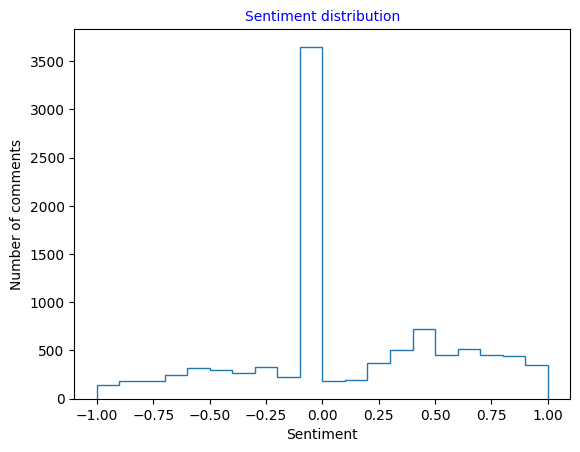

In [15]:
plt.stairs(counts, ranges, label='Simple histogram') 
plt.xlabel('Sentiment') 
plt.ylabel('Number of comments') 
# displaying the title
plt.title(label="Sentiment distribution",
          fontsize=10,
          color="blue")

In [32]:
pos_num = sum(counts[10:])
neg_num = sum(counts[:9])
net_num = counts[9]
print(f'Pos number: {pos_num}, Neg number: {neg_num}, Net_number: {net_num}')

Pos number: 4177, Neg number: 2174, Net_number: 3649


Looking at the distribution we can see that value 0 is the most common, however postive sentiment is more numerous than negative or neutral.

## Now lets look at  upvotes vs sentiment

In [18]:
def sentiment_conversion(value):
    if value < 0:
        return 'neg'
    elif value == 0:
        return 'neut'
    else:
        return 'pos'
# based on the value assign negative, positive or neutral sentiment
rdd3 = results.rdd.map(lambda x:  (x["id"],x["body"],x["score"], sentiment_conversion(x['sentiment'])  )) # sia.polarity_scores(x['body'])["compound"]

In [21]:
results2=rdd3.toDF(["id","body","score","sentiment"])
results2.show()

+-------+--------------------+-----+---------+
|     id|                body|score|sentiment|
+-------+--------------------+-----+---------+
|dnqik14|            A quarry|    3|     neut|
|dnqik15|[Salutations! I'm...|    3|      neg|
|dnqik16|I got into baseba...|    2|      neg|
|dnqik17|        FUCKING TORY|   18|     neut|
|dnqik18|I see a water dra...|    1|     neut|
|dnqik19|Wait. The Michiga...|    1|      pos|
|dnqik1a|              ye fam|    2|     neut|
|dnqik1b|143417804| &gt; U...|    1|      pos|
|dnqik1c|That is some chic...|    2|      neg|
|dnqik1d|Does he even know...|    1|     neut|
|dnqik1e|            Tequila.|    2|     neut|
|dnqik1g|your heart beats ...|    1|      neg|
|dnqik1h|&gt; Subscribe: /...|    1|     neut|
|dnqik1i|you're really ign...|    2|      neg|
|dnqik1j|lets see how deep...|    1|     neut|
|dnqik1k|You are arguing t...|    2|      neg|
|dnqik1l|I'm thinking abou...|    2|      pos|
|dnqik1m|[Original post](h...|    1|      pos|
|dnqik1n|I th

In [26]:
rdd4 = results2.rdd.map(lambda x: 
    (x['sentiment'],1)).reduceByKey(add)

In [29]:
rdd4.take(3)

[('neut', 3504), ('neg', 2319), ('pos', 4177)]

Looking at above output we can clearly see that the positive comments are getting the highest amount of upvotes and negative comments are getting the lowest amount of upvotes. Moreover looking at previous example that the positive and negative sentiment is the most numerous, we cann 